In [6]:
import spacy
nlp = spacy.load("en_core_web_sm")
doc = nlp(u'A man and a boy are playing computer and sitting on the ground in the office. A woman is presenting a chart and a picture. A boy sits on the chair and laughing at the dog. A boy sits on the chair and laughing. A boy stands laughing. A man and a boy are talking to each other. A girl is talking to his friend. There are some trees and plants and flowers in the park. An alien is standing. There lies a tree. A toy is played by a boy. Lying on the sofa. The boy plays in the park.')
# 'he is '
# 'mike is'
# Invalid case:
# doc = nlp(u'A boy sits on the chair and a girl is laughing at the dog.')
doc = nlp(u'A man is sitting on a printer looking at his phone. A man and a woman are bending over to file.')
for token in doc:
    print("{2}({3}-{6}, {0}:{1}-{5})".format(token.text, token.tag_, token.dep_, token.head.text, token.head.tag_, token.i+1, token.head.i+1))
spacy.displacy.render(doc, style='dep')

det(man-2, A:DT-1)
nsubj(sitting-4, man:NN-2)
aux(sitting-4, is:VBZ-3)
ROOT(sitting-4, sitting:VBG-4)
prep(sitting-4, on:IN-5)
det(printer-7, a:DT-6)
pobj(on-5, printer:NN-7)
acl(printer-7, looking:VBG-8)
prep(looking-8, at:IN-9)
poss(phone-11, his:PRP$-10)
pobj(at-9, phone:NN-11)
punct(sitting-4, .:.-12)
det(man-14, A:DT-13)
nsubj(bending-19, man:NN-14)
cc(man-14, and:CC-15)
det(woman-17, a:DT-16)
conj(man-14, woman:NN-17)
aux(bending-19, are:VBP-18)
ROOT(bending-19, bending:VBG-19)
prt(bending-19, over:RP-20)
aux(file-22, to:IN-21)
advcl(bending-19, file:VB-22)
punct(bending-19, .:.-23)


In [6]:
import spacy
nlp = spacy.load("en_core_web_md")

In [7]:
doc = nlp('good bad')
doc[0].similarity(doc[1])

0.73550904

In [8]:
from query_relatedness import query_simi
query_simi('good','bad')

Query Request: 1 bad - good


0.283

In [344]:
# difficult cases:
##  "a man is sitting next to a desk": desk should be in surrounding (weak interaction)
##  "a man is watching a picture": picture should be in surrounding (weak interaction)
##  "a man is walking on a street": street should be in surrounding
### in all cases, the key is that there's no such combinations in the layer base

In [354]:
### entity -> coreference(typically same surroundings refers to the same one. But characters refer to different one.) -> infer subjects (in a missing nsubj case) -> infer relations (add it as long as there exists)

#### infer implicits:
## direct verbs can be a fixed edge
## indirect verb can be a variable edge. It can either be replaced or removed

In [384]:
# 4 nodes -> 6 edges -> 2^6 possible cases
# 2**6
# two expensive

In [385]:
## then how to partition nodes? all possible ways
# a man is talking to a woman -> group(have[man(talk) and woman(talk)]
# a man is watching chart -> man | chart (because there's no such combinations in the base)

In [386]:
from more_itertools import set_partitions
list(set_partitions([1,2,3,1], 2))

[((1,), (2, 3, 1)),
 ((2,), (1, 3, 1)),
 ((3,), (1, 2, 1)),
 ((1,), (1, 2, 3)),
 ((1, 2), (3, 1)),
 ((1, 3), (2, 1)),
 ((1, 1), (2, 3))]

In [351]:
# so this is a global optimization
# 4 nodes = 15 partitions
# 1 partion = 1~3 * 100 layer comparison

In [ ]:
# infer implicits before or after partition?


In [ ]:
# metric: still weighted IOU + verb relatedness

In [341]:
from spacy.matcher import Matcher
from tools.text_process import SimpleLemmaTokenizer
import re

# print([(t.text, t.pos_) for t in doc])
# tokenizer = SimpleLemmaTokenizer()


def get_verb_phrase(doc):
    matcher = Matcher(doc.vocab)
    pattern = [{"POS": "VERB"},
               {"POS": {"IN": ["ADV","ADP","PART"]}, "OP": "*"}]
    matcher.add("Verb Phrase:", None, pattern)
    phrases = []
    for _, start, end in matcher(doc):
        phrase = doc[start:end]
        # remove single stop words such as 'is' 'are'
        if len(phrase) == 1:
            if phrase[0].is_stop:
                continue
        
        # greedy match
        same_roots = [p for p in phrases if p.root == phrase.root]
        if same_roots:
            assert(len(same_roots) == 1)
            p_ = same_roots[0]
            if len(p_) < len(phrase):
                phrases.remove(p_)
                phrases.append(phrase)
        else:
            phrases.append(phrase)
    return phrases       

def get_noun_phrase(doc):
    return list(doc.noun_chunks)
    
def is_connect(nop, vp):
    for v in vp:
        # check if two are directly connected in the dependency tree
        if nop.root.head == v or v.head == nop.root:
            return nop.root.dep_
#   this allow verbs to be reused, move to the end of the pipeline
#     for c in np.conjuncts:
#         if c.head == v:
#             return c.dep_[1:]
    for v in vp.conjuncts:
        if nop.root.head == v or v.head == nop.root:
            return nop.root.dep_
    return None

def to_subj_or_obj(dep, n, v):
    if not dep: return None
    if re.match(r'\D*subj\D*', dep): return 'subj'
    if re.match(r'\D*obj\D*', dep): return 'obj'
    raise ValueError('Unexpected dependency tag! %s' % dep, n, v)
    
def is_SVO(n1, n2, v):
    """
    determine the connection is valid in a subj-verb-obj form
        two subjects or two objs are invalid.
            ! E.g. a man and a boy are playing computer.
                "man" and "boy" are not connected.
    """
    conns = [to_subj_or_obj(is_connect(n1, v), n1, v),
             to_subj_or_obj(is_connect(n2, v), n2, v)]
    conns = [c for c in conns if c]
    # only if subj and obj occur together, SVO stands
    if len(set(conns)) == 2:
    # if len(conns) == 2:
        return True
    return False

def conjunts_expand(conns, nps):
    """
    The conjunctions of nouns share the same verbs and objects
    E.g. "A man and a boy are playing computer."
        boy will be conjuncted to man
    To-do: inherit dep_ tag
    """
    conns_c = []
    for n1, n2, dic in conns:
        for c in n1.conjuncts:
            for n_ in nps:
                if c in n_:
                    conns_c.append((n_, n2, dic))
        for c in n2.conjuncts:
            for n_ in nps:
                if c in n_:
                    conns_c.append((n1, n_, dic))
    conns.extend(conns_c)
    return conns
            
def get_edges(nouns, verbs):
    """
    if passive, needs to rectify the order
    """
    connections = []
    # nouns_ = nouns.copy()
    _verbs = []
    for n1, n2 in itertools.combinations(nouns, 2):
        for v in verbs:
            if is_SVO(n1, n2, v):
                connections.append((n1, n2, {'verb': v}))
                _verbs.append(v)
                # if n1 in nouns_: nouns_.remove(n1)
                # if n2 in nouns_: nouns_.remove(n2)
    conjunts_expand(connections, nouns)
    return connections, [v for v in verbs if v not in _verbs] #, nouns_

def append_verbs(verbs, nouns):
    """
    absorb verbs with no subject or object
    to-do: fill in missing subjects or objects using knowledge
    """
    print(verbs, nouns)
    noun_comps = []
    _verbs = []
    for v in verbs:
        for n in nouns:
            # if n.root.text == 'alien': print(n,v)
            # print(v)
            if is_connect(n, v):
            # if n.root in v.root.children:
                # print(n,v)
                noun_comps.append((n, {'verb': v}))
                _verbs.append(v)
    return noun_comps, [v for v in verbs if v not in _verbs]
                

print(doc)
print()
print(get_verb_phrase(doc))
nouns = get_noun_phrase(doc)
# edges, verbs, nouns_ = get_edges(get_noun_phrase(doc), get_verb_phrase(doc))
edges, verbs = get_edges(get_noun_phrase(doc), get_verb_phrase(doc))
# print(verbs)
noun_comps, verbs = append_verbs(verbs, get_noun_phrase(doc))
edges, verbs, noun_comps


A man and a boy are playing computer and sitting on the ground in the office. A woman is presenting a chart and a picture. A boy sits on the chair and laughing at the dog. A boy sits on the chair and laughing. A boy stands laughing. A man and a boy are talking to each other. A girl is talking to his friend. There are some trees and plants and flowers in the park. An alien is standing. There lies a tree. A toy is played by a boy. Lying on the sofa. The boy plays in the park.

[playing, sitting on, presenting, sits on, laughing at, sits on, laughing, stands, laughing, talking to, talking to, standing, lies, played by, Lying on, plays in]
[laughing, stands, laughing, talking to, standing, lies, Lying on] [A man, a boy, computer, the ground, the office, A woman, a chart, a picture, A boy, the chair, the dog, A boy, the chair, A boy, A man, a boy, A girl, his friend, some trees, plants, flowers, the park, An alien, a tree, A toy, a boy, the sofa, The boy, the park]


([(A man, computer, {'verb': playing}),
  (A man, computer, {'verb': sitting on}),
  (A man, the ground, {'verb': sitting on}),
  (A woman, a chart, {'verb': presenting}),
  (A boy, the chair, {'verb': sits on}),
  (A boy, the dog, {'verb': laughing at}),
  (A boy, the chair, {'verb': sits on}),
  (A girl, his friend, {'verb': talking to}),
  (A toy, a boy, {'verb': played by}),
  (The boy, the park, {'verb': plays in}),
  (a boy, computer, {'verb': playing}),
  (a boy, computer, {'verb': sitting on}),
  (a boy, the ground, {'verb': sitting on}),
  (A woman, a picture, {'verb': presenting})],
 [laughing],
 [(the chair, {'verb': laughing}),
  (A boy, {'verb': stands}),
  (A man, {'verb': talking to}),
  (An alien, {'verb': standing}),
  (a tree, {'verb': lies}),
  (the sofa, {'verb': Lying on})])

In [332]:
for n1, n2, v in edges:
    print((n1, n1.root.dep_), (n2, n2.root.dep_))

(A man, 'nsubj') (computer, 'dobj')
(A man, 'nsubj') (computer, 'dobj')
(A man, 'nsubj') (the ground, 'pobj')
(A woman, 'nsubj') (a chart, 'dobj')
(A boy, 'nsubj') (the chair, 'pobj')
(A boy, 'nsubj') (the dog, 'pobj')
(A boy, 'nsubj') (the chair, 'pobj')
(A girl, 'nsubj') (his friend, 'pobj')
(A toy, 'nsubjpass') (a boy, 'pobj')
(a boy, 'conj') (computer, 'dobj')
(a boy, 'conj') (computer, 'dobj')
(a boy, 'conj') (the ground, 'pobj')
(A woman, 'nsubj') (a picture, 'conj')


In [342]:
# we could modify the dep_ tags
## so: if passive, reverse the order and give correct tag
##     if conj, inherit the tag from its parent
## knowledge:
##     fill in missing ends
##     assign subject object tag according to the knowledge, in this way we don't need to modify dep_ tags
doc[0].dep_ = 'n'
doc[0].dep_

'n'

In [322]:
# erroneous conj between chair and laughing
print(noun_comps[0][0].root.sent)
# xcomp
print(verbs[0].sent)

A boy sits on the chair and laughing.
A boy stands laughing.


In [229]:
# still needs coreference resolution
# senior subjects take all the objects
# but rest subjects still got the verb

In [328]:
print(nouns)

[A man, a boy, computer, the ground, the office, A woman, a chart, a picture, A boy, the chair, the dog, A boy, the chair, A boy, A man, a boy, A girl, his friend, some trees, plants, flowers, the park, An alien, a tree, A toy, a boy, the sofa]


NodeView((A man, a boy, computer, the ground, the office, A woman, a chart, a picture, A boy, the chair, the dog, A boy, the chair, A boy, A man, a boy, A girl, his friend, some trees, plants, flowers, the park, An alien, a tree, A toy, a boy, the sofa))

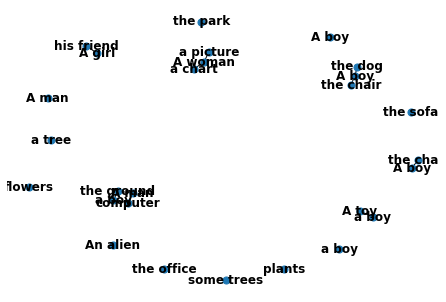

In [330]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from(nouns)
G.add_nodes_from(noun_comps)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos=pos, node_size=50)
# nx.draw_networkx_labels(G, pos=pos)
# nx.draw_networkx_edges(G, pos=pos, edge_color='k', width=1)
nx.draw(G, with_labels=True, font_weight='bold', node_size=50)
edge_labels = nx.get_edge_attributes(G,'verb')
# nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
G.nodes()

In [188]:
G.edges

EdgeView([(A man, computer), (A man, the ground), (a boy, computer), (a boy, the ground), (A woman, a chart), (A woman, a picture), (A girl, the chair), (A man, the sofa)])

In [67]:
a,b,c = (1,2,{'a':1})
print(a,b,c)

1 2 {'a': 1}


In [3]:
from models.pipeline import Translate
from tools.containers import Node
translate = Translate()
translate.entity_simi([Node('man','subj'),Node('woman','subj')],[Node('woman','subj'),Node('man','subj')])
# translate.entity_simi([Node('man','subj'),Node('woman','subj')],[Node('woman','subj')])

1.0

In [23]:
set1 = [Node('man','subj'),Node('woman','subj'), Node('woman','subj')]
set2 = [Node('man','subj'),Node('woman','subj')]
len([n for n in set2 if n in set1])/(len(set1)+len(set2))*2

0.8

In [85]:
# mis-spelled words
from query_relatedness import query_simi
query_simi('pohone','phone')
query_simi('lie_on','lie')

0.429

In [27]:
a = ['man','man']
a.remove('man')
a.pop()
a

[]

In [14]:
# similarity measure has serious problem!
# should use IOU instead. Since all keywords has already bound

In [3]:
# from rules.labels import subjects
from tools.knowledge import LayerBase, TextBase
layerbase = LayerBase()
# prs_subjects = set([subj for subj in layerbase.entities_['subj'] if subj in subjects['character']])
# prs_subjects

In [2]:
sorted([(layer, layer.src) for layer in layerbase.layer_vocab_])

[(#accessory, 'images/Game_day.svg'),
 (#accessory(book), 'images/podcast.svg'),
 (#accessory(have[circle,square]), 'images/portfolio_update.svg'),
 (#accessory(have[diamond,plant]), 'images/problem_solving.svg'),
 (#accessory(have[dot]), 'images/product_hunt.svg'),
 (#accessory(have[guardrail]), 'images/queue.svg'),
 (#accessory(have[leaf,plant]), 'images/word_of_mouth.svg'),
 (#accessory(have[leaf,rock]), 'images/product_teardown.svg'),
 (#accessory(have[leaf]), 'images/to_do_list.svg'),
 (#accessory(have[plant]), 'images/weather.svg'),
 (#accessory(have[sign,leaf]), 'images/questions.svg'),
 (#accessory(have[tree]), 'images/projections.svg'),
 (#alien(have[robot],stand), 'images/Firmware.svg'),
 (#alien(have[snowman]), 'images/Frozen.svg'),
 (#background, 'images/weather.svg'),
 (#chart(have[computer]), 'images/posting_photo.svg'),
 (#chart(have[diagram,arrow]), 'images/process.svg'),
 (#chart(have[folder,paper]), 'images/Folder.svg'),
 (#chart(have[list,paper]), 'images/to_do_list.

In [7]:
# similairties between subjects: the largest common subset
#     E.g. 1. text: man man and base: man woman
#              man - man: 1 + man - woman: 0.5
#          2. TEXT: man man and BASE: man
#              man - man: 1
#              so choose man and woman


In [14]:
translate = Translate()
translate('gaming')[0].layername

NameError: name 'Translate' is not defined

In [1]:
from tools.common import wait
wait(1)

In [5]:
class Test:
    def __init__(self):
        self.exit = False
    
    def __call__(self):
        for i in range(20):
            if not self.exit:
                print(i)
                wait(1)
                
test = Test()
test()

0
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
101
111
121
131
141
151
161
171
181
191


In [6]:
test.exit = True

In [32]:
# two men
# freelancer: use computer shoud be play computer; each action must bound, if not, skip
# Fitness_tracker: -> play: phone -> phone, but should phone -> other, this is dependent on how strict when bind
# videographer: ->hold: {camera->phone} but should other: camera. Somehow don't fix the priority but use the similarity to select between all methods (syntactical, free-ground, subject-specified ground, action-specified ground)
# Firmware: raise: {robot->arm} but should alien -> robot. Use similarity to select methods

In [34]:
# really needs to set threshold, let's take maximum anyway

In [33]:
import glob
import re
from tools.containers import Picture
ground = Ground()
for txt_name in glob.glob('text/*.txt'):
    print(' -------------------------- ')
    name = re.findall(r'text/(\w+).txt', txt_name)[0]
    print(name)
    # name = 'wind_turbine'
    print(Picture('images/%s.svg' % name).layers_)
    print(ground('text/%s.txt' % name))

 -------------------------- 
road_sign
(#wild(have[tree,sign,sun]), #man(stand))
A man is standing in front of trees and signs.
[man, standing, trees, signs]
({man->man: {stand->stand: set()}}, {->wild: {->have: {sign->sign, tree->tree}}})
 -------------------------- 
to_do_list
(#background, #accessory(have[leaf]), #accessory(have[leaf]), #chart(have[list,paper]), #woman(bend,write))
A woman is writing paper with a pen.
[woman, writing, paper, pen]
({woman->woman: {write->write: {paper->pencil}, ->hold: {pen->pencil}}},)
 -------------------------- 
Gaming
(#background, #wild(have[plant]), #other(have[gamepad]), #man(touch,stand))
A man touches a gamepad.
[man, touches, gamepad]
({man->man: {touch->touch: set()}}, {->other: {->have: {gamepad->gamepad}}})
 -------------------------- 
Fishing
(#background, #wild(have[lake,hill,cloud]), #wild(have[boat]), #man(fishing,stand,hold[fishing_rod]))
A man is fishing on the lake.
[man, fishing, lake]
({man->man: {fish->fishing: set(), ->hold: {

/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:70: UserWarning: Tokens not exhausted!


-> left ungrounded tokens: [past]
({woman->woman: {walk->walk: set()}}, {->wild: {->have: {fish->fish, tank->fish_tank}}})
 -------------------------- 
Firmware
(#background, #alien(have[robot],stand), #man(exercise,step_on[stone]), #man(work,play[computer],sit))
A man played the computer. A man stepped on the stone and exercised. They had a robot.
[man, played, computer, man, stepped, stone, exercised, robot]
({man->man: {play->play: {computer->computer}, ->step_on: {stone->stone}, ->raise: {robot->arm}}}, {man->man: {step->step_on: set(), exercise->exercise: set()}})
 -------------------------- 
visual_data
(#background, #wild(have[tree]), #man(collect[data]))
A man is standing to collect data.
[man, standing, collect, data]
({man->man: {stand->stand: set(), collect->collect: {datum->data}}},)
 -------------------------- 
viral_tweet
(#wild(have[hill,cloud]), #accessory(have[leaf]), #wild(have[balloon]), #woman(sit,hold[phone]))
A woman is sitting in a hot air balloon.
[woman, sittin

/Users/dongjustin/miniconda2/envs/text2scene/lib/python3.7/site-packages/ipykernel_launcher.py:65: UserWarning: Verbs not exhausted!


-> left ungrounded tokens: [couple]
({->woman: {lie->lie: set()}}, {->wild: {->have: {beach->beach, sun->sun}}})
 -------------------------- 
wind_turbine
(#background, #other(have[windmill]), #woman(walk,watch))
A woman is walking in front of three windmills.
[woman, walking, windmills]
({woman->woman: {walk->walk: set()}}, {->other: {->have: {windmill->windmill}}})
 -------------------------- 
Folder
(#chart(have[folder,paper]), #man(stand))
A man stands next to the folder.
[man, stands, folder]
({man->man: {stand->stand: set()}}, {->chart: {->have: {folder->folder}}})
 -------------------------- 
track_and_field
(#background, #woman(exercise,run_over[hurdle]))
A woman is running over hurdles.
[woman, running, hurdles]
({woman->woman: {run->run: set(), ->run_over: {hurdle->hurdle}}},)
 -------------------------- 
virtual_reality
(#background, #man(lie,watch[movie]))
A man is lying watching a movie.
[man, lying, watching, movie]
({man->man: {lie->lie: set(), watch->watch: {movie->movi

In [262]:
#  web development
#  Text: A woman is playing with her computer next to a web page.
#  Trouble: two plays: first with woman, second proposed by computer

#  weather
#  Text: A man is standing to give the weather report.
#  Trouble: weather -> wind but should "weathe report" -> "bulletin"

#  videographer
#  Text: A man is standing against the camera.
#  Trouble: "camera" is bound to "phone" under "man", because they are similar. No way it can be bound to "camera" in "other" because bindind to subjects in the list is prior

#  transfer_money
#  Text: A man is standing and a woman is sitting with a computer to transfer money.
#  Trouble: "money" is syntactically connected to transfer, thus can't be further grounded into charts

#  track and field: A woman is running over hurdles.
#  hurdle isn't captured by woman. Extend the object capture to any subject

#  A man talks with his friend under the tree.
#   "friend" is not bound but is important. similar cases include couple.

# For_sale.txt [resolved]
#    syntactically bound surrounding subjects have no action
#    thus add default action 

# Follow_me_drone
#    "woman watch drone" rather than "woman watch" and "other drone"
#    this is a syntactical grounding case, thus nothing can be done
#    may require the difference between strong interaction and weak interaction. E.g. play and watch
#    need special care when compare the similarity. keywords in a bag may be suitable in this case. Previously we propose layerwise retrieval, now picture level? The slicing is already done anyway. But then we cannot ensure, e.g. two men in a group is correctly bound, duplicate subjects information is lost after bagging.


# text/Focus.txt [resolved]
#    tree -> home rather than tree -> wild
#    add a new ordering key in find_most_simi_subjs, the frequency of this object under this subject 
#    similarly, add the frequency key in get_simi_key
#        in fact, this is the frequency prior

# text/Flowers.txt
#    grass -> leaf but should grass -> plant

# 'text/Firmware.txt [resolved]
#    robot can not be grounded to alien, because it's alien have robot, which is an oject
#    -> ground to any subjects which have a "have" action, not just surrounding subjects

# wild should be separate from man and boy? [resolved]
#    generally if both are characters then in a layer group? surrounding cannot be in a group technically

# chair should be with sit on?
# but sofa should not be with lie on
# what to do

# in alien, lie is not bound to any keyword
# because lie isn't in the collocations of alien

In [40]:
# seemly that we don't need a second step

### test

In [16]:
### group layer exclusion check
sorted(list(layerbase.layer_vocab_))[12].nested_entities_

{man1(subj): {sit(act): set(),
  drink(act): {beer(obj)},
  raise(act): {arm(obj)}},
 man2(subj): {sit(act): set(), raise(act): {arm(obj)}, eat(act): {chips(obj)}}}

{'subj': {man(subj): 6}, 'act': {sit(act): 6, drink(act): 3, raise(act): 6, eat(act): 3}, 'obj': {beer(obj): 3, arm(obj): 6, chips(obj): 3}}
{'subj': {man(subj): 6}, 'act': {sit(act): 6, drink(act): 3, raise(act): 6, eat(act): 3}, 'obj': {beer(obj): 3, arm(obj): 6, chips(obj): 3}}


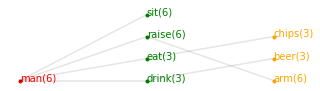

In [17]:
### absorption check
from tools.containers import LayerName
from tools.image_process import getLayerNames
layer = LayerName(getLayerNames('images/Game_day.svg')[-1])#
layer_c = LayerName()
# layer_c.triples_
# print(layer_c.entities_['subj'])
layer_c.absorb(layer)
layer_c.absorb(layer)
layer_c.absorb(layer)
layer_c.triples_
# print(layer)
# print(layer.entities_)
# layer.collapse_subj()
# print(layer.entities_)
# layer.print_()
# layer_c.plot()
print(layer_c.entities_) # plot()
print(layer_c._get_entities())
layer_c.plot()